# Hawaii Climate Analysis

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables- SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
 # create engine to hawaii.sqlite
    
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table

measure = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB

session = Session(engine)

In [9]:
#inspector
inspector = inspect(engine)
    

In [10]:
# Columns for measurement table

columns_measure = inspector.get_columns('measurement')
for c in columns_measure:
    print(c['name'],c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
#Columns for station table

columns_station = inspector.get_columns('station')
for s in columns_station:
    print(s['name'],s['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Precipitation Analysis

#### Design a query to retrieve the last 12 months of precipitation data and plot the results. 

In [12]:
# Find the most recent date in the data set (Max date)

recent_date = session.query(func.max(func.strftime("%Y-%m-%d", measure.date))).limit(5).all()
recent_date[0][0]

'2017-08-23'

In [13]:
 # Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores

precip_data = session.query(func.strftime("%Y-%m-%d", measure.date), measure.prcp).\
filter(func.strftime("%Y-%m-%d",measure.date) >= dt.date(2016,8,23)).all()

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column

precip_df = pd.DataFrame(precip_data, columns = ['date', 'precipitation'])

#set the index to the date column

precip_df.set_index('date', inplace = True)

# Sort the dataframe by date
precip_df = precip_df.sort_values(by='date')
precip_df.head(10)

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
2016-08-23,0.02
2016-08-24,0.08
2016-08-24,2.15


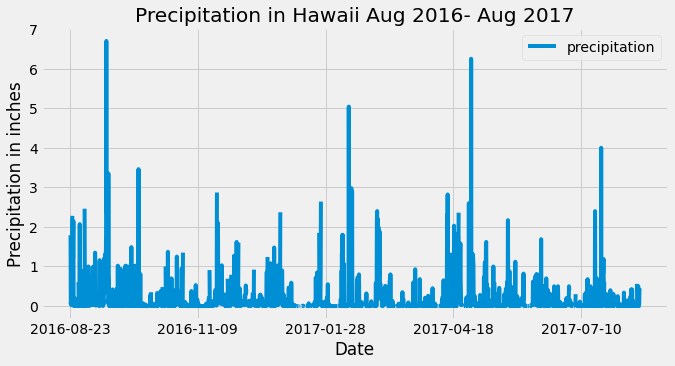

<Figure size 432x288 with 0 Axes>

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data

fig, ax = plt.subplots(figsize = (10, 5))
precip_df.plot(ax = ax, x_compat = True)

#Plot Labels

ax.set_xlabel('Date')
ax.set_ylabel('Precipitation in inches')
ax.set_title("Precipitation in Hawaii Aug 2016- Aug 2017")
plt.show()


#Save Plot 

plt.savefig("precip.png")

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [17]:
 # Design a query to calculate the total number stations in the dataset

stations_total = session.query(func.count(station.station)).all()
stations_total

[(9)]

In [18]:
 # Design a query to find the most active stations
 stations_active = session.query(measure.station, func.count(measure.station)).group_by(measure.station).order_by(func.count(measure.station).desc()).all()
stations_active


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
#most active station/ most rows

station_mostactive = stations_active[0]
station_mostactive

('USC00519281', 2772)

In [20]:
id_mostactive = station_mostactive[0]
id_mostactive

'USC00519281'

In [21]:
# Using the most active station id from the previous query, calculate the lowest temperature

lowtemp = (session.query(measure.tobs)
                     .filter(measure.station == id_mostactive)
                     .order_by(measure.tobs.asc())
                     .first())
lowtemp = lowtemp[0]
lowtemp


54.0

In [22]:
# Using the most active station id from the previous query, calculate the highest temperature.

hightemp = (session.query(measure.tobs)
                      .filter(measure.station == id_mostactive)
                      .order_by(measure.tobs.desc())
                      .first())
hightemp = hightemp[0]
hightemp

85.0

In [23]:
# Using the most active station id from the previous query, calculate the average temperature.

avgtemp = session.query(measure.station, func.avg(measure.tobs)).filter(measure.station == id_mostactive).all()
avgtemp

[('USC00519281', 71.66378066378067)]

In [24]:
# Query the last 12 months of temperature observation data for this station
# Using the most active station id

data = (session.query(measure.date, measure.tobs)
                   .filter(measure.date >dt.date(2016,8,23))
                   .filter(measure.station == id_mostactive)
                   .order_by(measure.date)
                   .all())

#data frame
temp_data = pd.DataFrame(data)
temp_data = temp_data.set_index('date')
temp_data = temp_data.sort_index(ascending=True)
temp_data.head(5)



,tobs
date,
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0


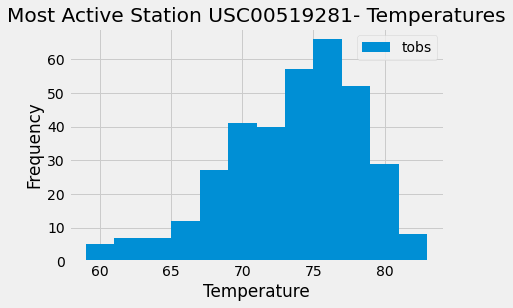

In [25]:
# Histogram

temp_data.plot(kind='hist', bins=12)
plt.title('Most Active Station USC00519281- Temperatures')
plt.xlabel('Temperature')

#Save Plot 

plt.savefig("tempdata.png")


# Close session

In [26]:
# Close Session
session.close()